# Simulating The Spread of Heat Through a Material
> Written by David Mascharka and Ryan Soklaski

## Understanding the Heat Propagation
In this problem, we will learn about a simple algorithm for numerically simulating the spread of heat through a material. We will want to use vectorization to write an efficient algorithm.

Imagine that we have a rectangular piece of steel. For now, let's treat this piece of steel as a 5x5 grid - we are only able to measure the average temperature of each of these 25 grid regions. Let's assume that steel starts off at a uniform 0-degrees. Thus, our temperature readout for each of its grid positions is:

```
                                0     0     0     0     0 
                                0     0     0     0     0 
                                0     0     0     0     0 
                                0     0     0     0     0 
                                0     0     0     0     0 
```

Now, we will clamp hot contacts, which are always at a constant 100-degrees, along the outer edges of the steel. Upon clamping these contacts, our temperature readout at time-0 becomes:

```
                               100   100   100   100   100
                               100    0     0     0    100
                               100    0     0     0    100
                               100    0     0     0    100
                               100   100   100   100   100
```

We will adopt the same indexing scheme as a 2D NumPy array. That is, element (i,j) of this grid is row-i, column-j in the grid. The top-left corner is located at (0, 0), and has a temperature of 100. 

Moving forward, we want to describe, numerically, how the heat from the contacts will spread through the material as time carries on. The heat equation is a partial differential equation that describes the flow of heat through space and time. In the following equation, the function $u(x, y, t)$ describes how much heat resides at the location $(x, y)$ at time $t$:

\begin{equation}
\frac{\partial u}{\partial t} - \alpha \left(\frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial^{2} u}{\partial y^{2}} \right)= 0
\end{equation}

Do not worry if you have no clue what a partial differential equation is! You do not need to know anything about the heat equation, we are simply providing some background here. 

What this equation ultimately says is that heat will spread such that a point will take on the average amount of heat among its neighboring points. Numerically, we can write this out as:

\begin{equation}
u^{(t)}_{ij} = \frac{u^{(t-1)}_{i+1,j} + u^{(t-1)}_{i-1,j} + u^{(t-1)}_{i,j+1} + u^{(t-1)}_{i,j-1}}{4}
\end{equation}

That is, $u^{(t)}_{ij}$ is the heat at grid-location $(i, j)$ at time-step $t$. It's value is given by the average of the heat of all four of its neighboring grid positions from time-step $t-1$. See that the right side of the equation averages the heat from above, below, left-of, and right-of $(i, j)$, at time-step $t-1$. This means of evolving the heat through our gridded material is known as the *finite difference method*.

Let's using the finite difference method to figure out what the distribution of heat looks like throughout our steel square at time-step 1. Keep in mind that we need not update any of the outer-edges of the steel - those positions are held at a fixed heat. We'll start at the upper-left corner and get

\begin{equation}
u^{t=1}_{1,1} = \frac{0 + 100 + 0 + 100}{4} = 50\\
u^{t=1}_{1,2} = \frac{0 + 100 + 0 + 0}{4} = 25\\
\end{equation}

and so on, yielding the heat distribution at timestep-1 of:
```
                                100   100   100   100   100
                                100    50    25    50   100
                                100    25     0    25   100
                                100    50    25    50   100
                                100   100   100   100   100
```

Repeating this process again will produce the heat distribution at timestep-2, and so on. After many iterations, we see the entire region becomes 100 degrees. This is because the heat from the edges flows inward until everything is the same temperature. This stabilized distribution of heat is known as the *steady state*. If we change the boundary conditions, i.e. change what we clamp to the edges of our steel, we will observe different steady states.


## Problem 1: A Simple Implementation of Finite Differences
Write a Python function that takes in a 2-dimensional numpy-array containing heat-values, and uses the finite difference method to produce the heat distribution for that material at the next time-step. Do this using simple for-loops to iterate over the values of the array.

Assume that the boundary-values of the array are fixed, so you need not update them. However, do *not* assume that the boundary values are all the same as one another, as they were in the preceding example.

import numpy as np
Also, be careful not to change the content of the array that your function is given. You need to use the values in that array, unchanged, to compute the new heat distribution. Consider making use of `np.copy` to create a copy of the input array (so that your new array will have the appropriate boundary values).

In [52]:
import numpy as np
test = np.array([[1,2,3],[4,5,6]])
print(test[0][1])
print(test[1][0])

# temp = []
# for i in range(2*3):
#     temp.append(0)
    
# ret = np.array(temp)
# ret.reshape(2,3)

2
4


In [53]:
# make sure to execute this cell so that your function is defined
# you must re-run this cell any time you make a change to this function
import numpy as np
def evolve_heat_slow(u):
    N = u.shape[0]
    M = u.shape[1]
    
    temp = []
    for i in range(N*M):
        temp.append(0.0)
    
    ret = np.array(temp)
    ret = ret.reshape(N,M)
#     print(ret)
    for i in range(N):
        for j in range(M):
            if i == 0 or j == 0 or i == N-1 or j == M-1:
#                 print(str(i) + " " + str(j))
                ret[i][j] = u[i][j]
                continue
            ret[i][j] = (u[i+1][j] + u[i-1][j] + u[i][j+1] + u[i][j-1])/4.0
#             print(ret)
    return ret
            
    """ Given a 2D array of heat-values (at fixed boundary), produces
        the new heat distribution after one iteration of the finite 
        difference method.
        
        Parameters
        ----------
        u : numpy.ndarray shape=(M, N)
            An MxN array of heat values at time-step t-1.
            (M and N are both at least 2)
        
        Returns
        -------
        numpy.ndarray, shape=(M, N)
            An MxN array of heat values at time-step t.
        """       
    # student code goes here

In [54]:
from bwsi_grader.python.heat_dispersion import grader
grader(evolve_heat_slow, grade_ver=1)


============================== ALL TESTS PASSED! ===============================
Your submission code: bw4c328516b4c813fe5f8394f4f6b83799336f22f27044cb26efb23cf8



Armed with this function, we will find the steady state of a more finely-gridded sheet of steel, with a less trivial set of boundary heat-values.

We will create an 80x96 grid with the following boundary conditions:

- Along the top row, we linearly increase the heat from 0 to 300 degrees from left to right
- Along the bottom row, we fade from 0 to 80 degrees at the middle and back to 0 on the right
- Along the left side, we linearly increase from 0 degrees at the bottom to 90 at the top (note that the very corner point is 0 from the 0 -> 300 continuum above)
- Along the right side, we linearly increase the heat from 0 to 300 degrees from bottom to top

In [55]:
# creating the 80x96-grid sheet with the non-trivial boundary conditions
# simply execute this cell; you need not change anything.

import numpy as np
# discretize our rectangle into an 80x96 grid
rows = 80     
columns = 96
u = np.zeros((rows, columns))

# set up the boundary conditions
u[0] = np.linspace(0, 300, columns)                # top row runs 0 -> 300
u[1:,0] = np.linspace(90, 0, rows-1)               # left side goes 0 -> 90 bottom to top
u[-1,:columns//2] = np.linspace(0, 80, columns//2) # 0 (left) to 80 (middle) along the bottom
u[-1,columns//2:] = np.linspace(80, 0, columns//2) # 80 (middle) to 0 (left) along the bottom
u[:,-1] = np.linspace(300,0,rows)                  # 0 -> 300 bottom to top along the right

Let's plot the initial condition for this steel sheet. You should see a "hot spot" in the top-right corner, and varying amounts of heat elsewhere on the boundary. Check that this corresponds to the boundary conditions that we imposed.

In [56]:
# execute this cell
%matplotlib inline

# matplotlib is a Python library used for visualizing data
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, ax = plt.subplots()
ax.imshow(u, cmap='hot');

<IPython.core.display.Javascript object>

Now, we will make an animation of the heat spreading through this material. However, our current implementation is too slow - let's time the amount of time required to evolve the heat in the material for 5000 iterations. This should take 20 sec - 1 minute.

In [57]:
%matplotlib inline

import time
slow = u.copy()
start = time.time()
for _ in range(100): # perform 5000 iterations to reach a steady state
    slow = evolve_heat_slow(slow)
t = round(time.time() - start, 1)
print("`evolve_heat_slow` took {} seconds to complete 5000 iterations".format(t))

`evolve_heat_slow` took 1.0 seconds to complete 5000 iterations


# Problem 2: A Vectorized Version of Finite Differences
Use NumPy array arithmetic to vectorize the finite-difference method that you implemented in problem #1. Your code should not utilize any for-loops.

In [58]:
def evolve_heat_fast(u):
    ret = u.copy()
    N = u.shape[0]
    M = u.shape[1]
    #Last one is exclusive!!
#     print(u)
#     print(u[0:N, 0:M])
#     print(u[0:N-3,1:M-2])
#     print(u[2:N-1,1:M-2])
#     print('asdf')
#     print(u[1:N-2,0:M-3])
#     print(u[1:N-2,2:M-1])
    ret[1:N-1,1:M-1] = (u[0:N-2,1:M-1] + u[2:N-0,1:M-1] + u[1:N-1,0:M-2] + u[1:N-1,2:M-0])/4
    return ret

In [59]:
from bwsi_grader.python.heat_dispersion import grader
grader(evolve_heat_fast, grade_ver=2)


============================== ALL TESTS PASSED! ===============================
Your submission code: bw95ca3a7cfec977141125d15af9059617240297927b952f8dfae97d2a



Now let's use our vectorized code to perform 5000 iterations to evolve the heat in our system. This should be nearly 100-times faster than our original implementation.

In [60]:
# execute this cell

import time
fast = u.copy()
start = time.time()
all_frames = []
for _ in range(5000):
    all_frames.append(fast.copy())
    fast = evolve_heat_fast(fast)
t = round(time.time() - start, 1)
print("`evolve_heat_fast` took {} seconds to complete 5000 iterations".format(t))

`evolve_heat_fast` took 0.4 seconds to complete 5000 iterations


Plotting the distribution of heat after 5000 time-steps of evolution. 

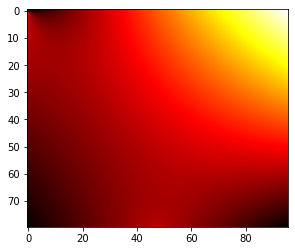

In [61]:
# execute this cell
%matplotlib inline

fig, ax = plt.subplots()
ax.imshow(fast, cmap='hot');

Even better, let's plot an animation of the heat spreading through the steel sheet! The animation will loop back to the beginning after playing through.

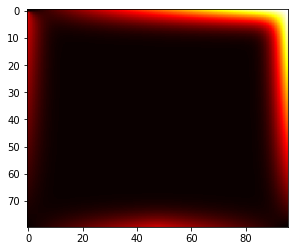

In [72]:
# execute this cell

%matplotlib inline

fig = plt.figure()
t = u.copy()
im = plt.imshow(t, animated=True, cmap='hot')

def updatefig(*args):
#     print(args)
    im.set_array(all_frames[args[0]])
    return im,

# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

ani = FuncAnimation(fig, updatefig, range(50), interval=1, blit=True, repeat=True,
                    repeat_delay=1000)


ani.save('test.mp4', extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
plt.show()

Try creating your own boundary conditions for the temperature distribution on this steel sheet. Reuse the code from above to animate how the heat spreads through it. Also congratulate yourself for numerically solving a fixed-boundary partial differential equation :)

......

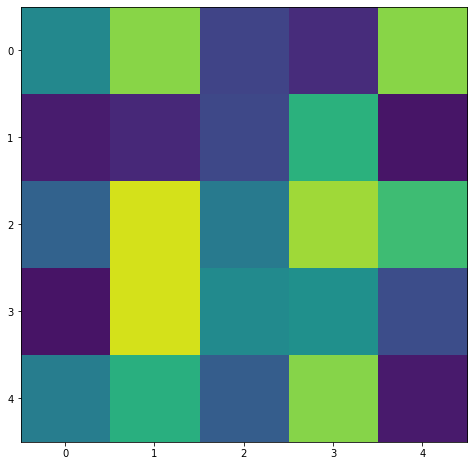

In [51]:
# Usually we use `%matplotlib inline`. However we need `notebook` for the anim to render in the notebook.
%matplotlib inline

import random
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.animation as animation


fps = 30
nSeconds = 5
snapshots = [ np.random.rand(5,5) for _ in range( nSeconds * fps ) ]

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = snapshots[0]
im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
)

writergif = animation.PillowWriter(fps=30)
anim.save('test.gif', writer=writergif)

plt.show()